In [1]:
!pip install openassetpricing

In [2]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5e/03/15cd49e855c62226ecf1831bbe4c8e73a4324856077a23c495538a36e557/xgboost-3.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 162.5 kB/s eta 0:15:23
   ---------------------------------------- 0.0/150.0 MB 186.2 kB/s eta 0:13:26
   ---------------------------------------- 0.1/150.0 MB 297.7 kB/s eta 0:08:24
   ---------------------------------------- 0.1/150.0 MB 554.9 kB/s eta 0:04:31
   ---------------------------------------- 0.5/150.0 MB 1.8 MB/s eta 0:01:21
   ---------------------------------------- 1.2/150.0 MB 3.6 MB/s eta 0:00:42
    --------------------------------------- 2.3/150.0 MB 6.3 MB/s eta 0:00:24
    ------------------------

In [3]:
import pandas as pd
import numpy as np
import openassetpricing as oap
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
linear_r = LinearRegression()
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
!pip install shap
import shap

MLP = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000)

openap = oap.OpenAP()

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/e5/bb/dc75933de86e6076f58cf68325877be952a97a371c26b252013f1258a5a7/shap-0.47.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
    --------------------------------------- 10.2/544.4 kB ? eta -:--:--
   -- ------------------------------------ 41.0/544.4 kB 653.6 kB/s eta 0:00:01
   ----------------------- ---------------- 317.4/544.4 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 544.4/544.4 kB 3.8 MB/s eta 0:00:00


In [4]:
pd.options.display.max_columns = 100

In [5]:
signal_df = openap.dl_signal_doc('pandas')

In [6]:
signal_df

,Acronym,Cat.Signal,Predictability in OP,Signal Rep Quality,Authors,Year,LongDescription,Journal,Cat.Form,Cat.Data,Cat.Economic,SampleStartYear,SampleEndYear,Acronym2,Evidence Summary,Key Table in OP,Test in OP,Sign,Return,T-Stat,Stock Weight,LS Quantile,Quantile Filter,Portfolio Period,Start Month,Filter,Notes,Detailed Definition
0,AbnormalAccruals,Predictor,1_clear,2_fair,Xie,2001,Abnormal Accruals,AR,continuous,Accounting,accruals,1971,1992,AccrAbn,t=8 port sort w/ nonstandard data lag,3,port sort size adjusted nonstandard,-1,0.916666667,8.43,EW,0.1,NA,12,6,NA,OP is aggressive and lags accounting data by o...,Define Accruals as net income (ib) minus opera...
1,Accruals,Predictor,1_clear,1_good,Sloan,1996,Accruals,AR,continuous,Accounting,accruals,1962,1991,Accruals,t > 4 in port sort CAPM alpha 12 month holding,6 year t+1,port sort size adjusted,-1,0.866666667,4.71,EW,0.1,NA,12,6,abs(prc)>5,Table 6 year t+1 hedge. Only size adjusted an...,Annual change in current total assets (act) mi...
2,AccrualsBM,Predictor,1_clear,1_good,Bartov and Kim,2004,Book-to-market and accruals,RFQA,discrete,Accounting,valuation,1980,1998,AccrualsBM,t=5.5 in long-short,3 mean diff 1-2,LS port,1,0.206,5.5,EW,0.2,NA,12,6,NA,NA,Binary variable equal to 1 if stock is in the ...
3,Activism1,Predictor,1_clear,1_good,Cremers and Nair,2005,Takeover vulnerability,JF,continuous,13F,other,1990,2001,Activism1,t=3.1 in port sort,3A VW BLOCK=4,port sort CAPM alpha,1,0.9025,3.13,VW,0.25,NA,1,6,NA,works a bit better EW in Tab 3,24 minus Governance Index (G). Set to missing ...
4,AM,Predictor,1_clear,1_good,Fama and French,1992,Total assets to market,JF,continuous,Accounting,valuation,1963,1990,AM,t=5.7 in univar reg,3 Ln(A/ME),univariate reg,1,NA,5.69,EW,NA,NA,12,6,NA,NA,Total assets (at) divided by market value of e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,SP_q,Placebo,indirect,NA,"Barbee, Mukherji and Raines",1996,Sales-to-price quarterly,FAJ,continuous,Accounting,valuation,1979,1991,Rev2Priceq,HXZ variant,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Ratio of annual sales (sale) to market value o...
327,tang_q,Placebo,indirect,NA,Hahn and Lee,2009,Tangibility quarterly,JF,continuous,Accounting,asset composition,1973,2001,Tangibilityq,HXZ variant,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Cash and short-term investments (che) plus .71...
328,Tax_q,Placebo,indirect,NA,Lev and Nissim,2004,Taxable income to income (qtrly),AR,continuous,Accounting,other,1973,2000,Tax_q,HXZ variant,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Ratio of Taxes paid and tax share of net incom...
329,WW_Q,Placebo,indirect,NA,Whited and Wu,2006,Whited-Wu index,RFS,continuous,Accounting,external financing,1975,2001,WW_Q,HXZ variant,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"Insignificant in original paper,",Group data by 3 digit SIC code and month to co...


## Sampling out 10 random, with quality good, and T-stat > 3 (statistical significance)


In [7]:
signal_df['T-Stat'] = pd.to_numeric(signal_df['T-Stat'], errors='coerce')
good_signals_df = signal_df[signal_df['Signal Rep Quality'] == '1_good']

strong_signals_df = good_signals_df[good_signals_df['T-Stat'] > 3]

sampled_strong_signals = strong_signals_df#.sample(n=40, random_state=42)
sampled_strong_acronyms = sampled_strong_signals['Acronym'].tolist()

sampled_strong_signals
filtered_signals_reset = sampled_strong_signals.reset_index(drop=True)
filtered_signals_reset[['Acronym', 'Signal Rep Quality', 'Return', 'T-Stat']]



,Acronym,Signal Rep Quality,Return,T-Stat
0,Accruals,1_good,0.866666667,4.71
1,AccrualsBM,1_good,0.206,5.50
2,Activism1,1_good,0.9025,3.13
3,AM,1_good,NA,5.69
4,AnnouncementReturn,1_good,NA,9.25
...,...,...,...,...
101,XFIN,1_good,1.29,5.70
102,zerotrade6M,1_good,0.806,4.06
103,zerotrade1M,1_good,0.56,3.46
104,zerotrade12M,1_good,0.846,4.40


In [8]:
signals = filtered_signals_reset['Acronym'].tolist() 

In [9]:
port_vw = openap.dl_port('deciles_vw', 'pandas', signals)
ls_df = port_vw[port_vw['port'] == 'LS']

One or more input predictors are not available.

Data is downloaded: 6s


In [10]:
ls_df

,signalname,port,date,ret,signallag,Nlong,Nshort
8700,AM,LS,1951-07-31,2.086206,NaN,34,34
8701,AM,LS,1951-08-31,2.936486,NaN,34,34
8702,AM,LS,1951-09-28,2.515863,NaN,34,34
8703,AM,LS,1951-10-31,3.344928,NaN,34,34
8704,AM,LS,1951-11-30,2.517470,NaN,34,34
...,...,...,...,...,...,...,...
870671,zerotrade6M,LS,2023-08-31,5.840727,NaN,242,242
870672,zerotrade6M,LS,2023-09-29,1.226106,NaN,241,241
870673,zerotrade6M,LS,2023-10-31,-0.487440,NaN,238,239
870674,zerotrade6M,LS,2023-11-30,-4.678486,NaN,238,238


In [11]:
ls_matrix = ls_df.pivot(index='date', columns='signalname', values='ret')
ls_matrix

signalname,AM,Accruals,Activism1,AnnouncementReturn,AssetGrowth,BMdec,BPEBM,BookLeverage,CBOperProf,CF,CPVolSpread,CashProd,ChAssetTurnover,ChEQ,ChNNCOA,ChNWC,ChTax,CompEquIss,CompositeDebtIssuance,CustomerMomentum,DelBreadth,DelCOA,DelCOL,DelDRC,DelEqu,DelFINL,DelLTI,DelNetFin,EarnSupBig,EarningsStreak,EntMult,EquityDuration,ExclExp,FirmAgeMom,Frontier,GrAdExp,IdioVol3F,Illiquidity,IndMom,IndRetBig,IntMom,IntanBM,IntanCFP,IntanEP,InvGrowth,InvestPPEInv,LRreversal,Leverage,Mom12m,Mom12mOffSeason,Mom6mJunk,MomOffSeason,MomOffSeason06YrPlus,MomOffSeason16YrPlus,MomSeason,MomSeason06YrPlus,MomSeason11YrPlus,MomSeason16YrPlus,MomSeasonShort,NOA,NetDebtFinance,NetEquityFinance,OPLeverage,PctAcc,PctTotAcc,PriceDelayRsq,RDS,REV6,ResidualMomentum,ReturnSkew,ReturnSkew3F,STreversal,ShareIss1Y,Size,SmileSlope,Tax,TotalAccruals,TrendFactor,VolSD,XFIN,betaVIX,dCPVolSpread,dNoa,dVolCall,fgr5yrLag,grcapx,grcapx3y,hire,retConglomerate,roaq,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1926-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.827749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.797129,NaN,-2.294774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.448235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.648866,NaN,-7.949931,NaN,NaN,NaN,NaN,NaN,6.323293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.434166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.834248,NaN,-1.666984,NaN,NaN,NaN,NaN,NaN,0.036220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.032380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.303247,NaN,-5.528865,NaN,NaN,NaN,NaN,NaN,7.334828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.503373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.256848,NaN,4.995551,NaN,NaN,NaN,NaN,NaN,-7.254370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-4.808055,3.106883,NaN,4.034015,-9.519793,-1.697203,-0.234906,2.360962,8.692678,9.501633,NaN,-2.051515,1.114309,-0.713090,0.923595,2.717452,4.474620,3.045221,6.933573,-2.671595,3.236632,-0.150450,-0.405116,4.473244,-8.265785,2.073515,-1.858090,0.141171,-3.589624,-1.551722,-5.919220,8.837482,-0.550740,-5.085860,-7.184456,-1.180653,14.532055,-1.116185,2.106005,0.930547,10.355904,-5.532417,-2.884931,-2.474950,-1.817942,3.749577,-11.021300,-4.796305,14.

In [12]:
ls_zscore = (ls_matrix - ls_matrix.mean()) / ls_matrix.std()
ls_zscore.dropna()

signalname,AM,Accruals,Activism1,AnnouncementReturn,AssetGrowth,BMdec,BPEBM,BookLeverage,CBOperProf,CF,CPVolSpread,CashProd,ChAssetTurnover,ChEQ,ChNNCOA,ChNWC,ChTax,CompEquIss,CompositeDebtIssuance,CustomerMomentum,DelBreadth,DelCOA,DelCOL,DelDRC,DelEqu,DelFINL,DelLTI,DelNetFin,EarnSupBig,EarningsStreak,EntMult,EquityDuration,ExclExp,FirmAgeMom,Frontier,GrAdExp,IdioVol3F,Illiquidity,IndMom,IndRetBig,IntMom,IntanBM,IntanCFP,IntanEP,InvGrowth,InvestPPEInv,LRreversal,Leverage,Mom12m,Mom12mOffSeason,Mom6mJunk,MomOffSeason,MomOffSeason06YrPlus,MomOffSeason16YrPlus,MomSeason,MomSeason06YrPlus,MomSeason11YrPlus,MomSeason16YrPlus,MomSeasonShort,NOA,NetDebtFinance,NetEquityFinance,OPLeverage,PctAcc,PctTotAcc,PriceDelayRsq,RDS,REV6,ResidualMomentum,ReturnSkew,ReturnSkew3F,STreversal,ShareIss1Y,Size,SmileSlope,Tax,TotalAccruals,TrendFactor,VolSD,XFIN,betaVIX,dCPVolSpread,dNoa,dVolCall,fgr5yrLag,grcapx,grcapx3y,hire,retConglomerate,roaq,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-07-31,0.446108,-0.497837,-0.976829,-2.833726,1.344135,-0.490937,1.340776,-2.031047,2.671150,1.296453,3.120262,0.178270,0.050574,1.692944,0.040859,0.803824,-0.792222,-1.561021,0.697315,-0.564690,-0.560891,1.227779,0.257222,1.060133,0.938378,1.053558,2.143519,-1.510857,0.451942,-0.445558,2.032977,1.128682,1.897309,1.362139,-1.963954,0.484332,2.001251,-0.493310,0.205627,-1.013961,0.954447,0.183242,0.828436,0.247027,0.141419,-0.274285,0.821538,0.910285,1.358705,0.185002,0.985551,0.585483,2.172276,-2.905936,-1.281467,0.257572,-0.572309,1.611260,0.104377,0.925783,1.603463,2.258056,1.958847,-0.149500,0.135705,0.833256,0.110082,-1.177298,-1.067839,2.207336,2.734687,-0.359004,0.791594,-0.363909,3.558484,1.834958,-0.534666,0.931104,0.050798,3.222098,1.209808,4.607086,0.338372,2.925100,2.329320,3.770207,3.128787,2.209599,1.237064,2.630968,0.032363,-2.226672,0.035258,0.462050,0.615621
2001-08-31,1.342226,-0.030305,-1.717198,0.173874,2.824636,1.190850,-0.711147,-0.684415,0.718854,-0.573896,0.598658,0.264333,-0.211039,2.329986,0.512575,0.663637,2.068288,-1.078182,1.951775,0.799217,0.260790,0.265461,0.897017,0.708305,2.323224,1.403178,2.502579,-2.291398,1.774855,-1.024442,1.574291,1.465239,1.139762,1.921444,-1.434670,1.243568,1.755542,1.362507,0.350878,0.844191,1.189195,-0.393753,1.798701,1.866787,1.450622,2.064286,1.227119,1.350940,1.511521,0.936374,1.559648,0.435092,2.376150,1.517987,-0.145034,-1.136595,0.819501,-0.012728,-0.052562,0.153033,1.838374,1.359373,-0.691635,-0.237748,0.628512,1.831893,0.789806,1.100913,-0.211277,-0.710957,-0.345947,-2.023210,2.860482,0.277415,-0.193497,-0.593496,-2.823047,-0.166275,1.601322,1.431939,-0.963186,0.366918,-0.018264,0.183423,2.458883,1.815118,1.593460,2.508098,2.255124,1.529688,0.584967,-1.142651,1.917250,1.490719,1.686262
2001-09-28,1.018330,0.239796,1.326554,0.344812,1.350201,-0.907282,1.195616,-1.996006,2.707409,-1.718254,1.794975,-0.801486,2.350534,2.290421,1.419095,0.613893,0.473372,-1.964202,2.374544,1.174459,-0.089831,0.158085,0.712487,-9.700129,1.407055,-0.414472,-0.617041,-1.936650,0.327863,-0.973426,0.374336,0.300643,2.997968,0.350645,-2.532865,-1.171577,2.373177,-0.400547,-0.075458,2.199761,2.556877,-0.533393,-0.656935,-0.379247,3.687068,0.245517,0.990236,1.440955,2.098251,1.044218,0.881626,-0.234692,0.733935,-1.179737,-0.659299,-0.024325,2.830750,4.510403,3.343103,1.387682,0.673507,3.054059,-0.561721,-0.752311,1.756096,3.298010,0.114487,1.881861,1.209249,0.344020,0.508636,-1.892235,0.201895,-0.325053,2.152790,-1.278066,0.673505,-0.780778,1.508656,3.520915,1.917974,-0.483655,2.233317,-0.418408,1.623447,4.387593,4.134552,1.264974,0.659566,2.931372,2.872654,-3.183265,1.543088,1.914919,1.353671
2001-10-31,-1.875340,-1.114565,1.333443,0.903334,-0.969020,-0.061073,-0.828846,3.009462,0.229157,1.670903,0.906505,-1.502664,-0.946303,-2.086735,-1.590101,-0.394813,-2.106900,1.474974,0.381278,-2.623982,-2.067261,-0.760988,-0.45

In [13]:
weights = filtered_signals_reset.set_index('Acronym')['T-Stat']
weights_aligned = weights.reindex(ls_zscore.columns).fillna(0)
weights_normalized = weights_aligned / weights_aligned.sum()
composite_signal = ls_zscore.dot(weights_normalized)
#composite_signal = composite_signal.dropna()

In [14]:
actual_ls_return = ls_matrix.mean(axis=1)
aligned = pd.concat([composite_signal, actual_ls_return.shift(-1)], axis=1).dropna()
aligned.columns = ['predicted', 'actual']

print(aligned.corr())

           predicted    actual
predicted   1.000000  0.217194
actual      0.217194  1.000000


In [15]:
#!pip install xgboost

In [16]:
algos = [linear_r, rf, xgb_model, svr, MLP]
X = ls_zscore.shift(1).interpolate().dropna()

y = ls_matrix.mean(axis=1).loc[X.index] 
print(X.isna().sum())

signalname
AM                    0
Accruals              0
Activism1             0
AnnouncementReturn    0
AssetGrowth           0
                     ..
std_turn              0
tang                  0
zerotrade12M          0
zerotrade1M           0
zerotrade6M           0
Length: 95, dtype: int64


In [17]:
def summary_stats(series):
    mean = series.mean()
    std = series.std()
    sharpe = mean / std
    t_stat = mean / (std / np.sqrt(len(series)))
    print(f"  Mean Return: {mean:.4f}")
    print(f"  Volatility: {std:.4f}")
    print(f"  Sharpe Ratio: {sharpe:.4f}")
    print(f"  T-Statistic: {t_stat:.4f}")
    print(f"  Start Date: {series.index.min()}")
    print(f"  End Date: {series.index.max()}")
    print("-" * 50)
    return " "

summary_stats(composite_signal)

  Mean Return: 0.0158
  Volatility: 0.2809
  Sharpe Ratio: 0.0563
  T-Statistic: 1.9298
  Start Date: 1926-02-27 00:00:00
  End Date: 2023-12-29 00:00:00
--------------------------------------------------


' '

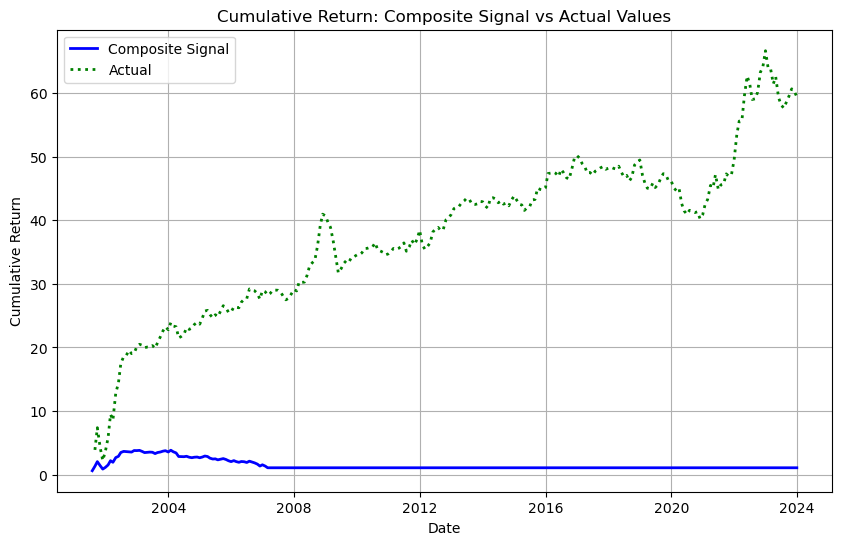

Correlation: -0.6378445398723323
Mean Squared Error: 1491.8858185102222


In [18]:
composite_cumulative_return = composite_signal.cumsum()
actual_cumulative_return = y.cumsum()
composite_cumulative_return = composite_cumulative_return.interpolate()
actual_cumulative_return = actual_cumulative_return.interpolate()


plt.figure(figsize=(10, 6))
plt.plot(composite_cumulative_return.index, composite_cumulative_return, label="Composite Signal", color='blue', linestyle='-', linewidth=2)
plt.plot(actual_cumulative_return.index, actual_cumulative_return, label="Actual", color='green', linestyle=':', linewidth=2)
plt.title("Cumulative Return: Composite Signal vs Actual Values")
plt.xlabel("Date")  # or "Index" if you're using indices
plt.ylabel("Cumulative Return")
plt.legend(loc='best')

plt.grid(True)
plt.show()

composite_cumulative_return, actual_cumulative_return = composite_cumulative_return.align(actual_cumulative_return, join='inner')
correlation = composite_cumulative_return.corr(actual_cumulative_return)
mse = mean_squared_error(actual_cumulative_return, composite_cumulative_return)

print(f"Correlation: {correlation}")
print(f"Mean Squared Error: {mse}")

In [ ]:
plt.figure(figsize=(10, 6))

colors = {
    "LinearRegression": 'blue',
    "RandomForestRegressor": 'orange',
    "XGBRegressor": 'red',
    "SVR": 'black',
    "MLPRegressor": 'yellow'
}
for algo in algos:
    algo.fit(X, y)
    y_test_pred = pd.Series(algo.predict(X), index=X.index)
    print(type(algo).__name__)
    print(f"  Mean Squared Error: {mean_squared_error(y, y_test_pred)}")
    print(f"  Correlation: {y_test_pred.corr(y)}")
    print(summary_stats(y_test_pred))
    plt.plot(y_test_pred.index, y_test_pred.cumsum(), label=f"Predicted - {type(algo).__name__}", color=colors[type(algo).__name__])

plt.plot(y.index, y.cumsum(), label="Actual", color='green', linewidth=2, linestyle=':')
plt.title("Cumulative Actual vs Predicted Values for All Models")
plt.xlabel("Index")
plt.ylabel("Cumulative Value")
plt.legend()  
plt.grid(True) 
plt.show()

LinearRegression
  Mean Squared Error: 0.65416543395014
  Correlation: 0.7161802013300207
  Mean Return: 0.2209
  Volatility: 0.8315
  Sharpe Ratio: 0.2657
  T-Statistic: 4.3573
  Start Date: 2001-08-31 00:00:00
  End Date: 2023-12-29 00:00:00
--------------------------------------------------
 
RandomForestRegressor
  Mean Squared Error: 0.19284389860961423
  Correlation: 0.9796216743234587
  Mean Return: 0.2192
  Volatility: 0.7643
  Sharpe Ratio: 0.2868
  T-Statistic: 4.7042
  Start Date: 2001-08-31 00:00:00
  End Date: 2023-12-29 00:00:00
--------------------------------------------------
 
XGBRegressor
  Mean Squared Error: 2.450920086288887e-07
  Correlation: 0.9999999251103365
  Mean Return: 0.2209
  Volatility: 1.1608
  Sharpe Ratio: 0.1903
  T-Statistic: 3.1212
  Start Date: 2001-08-31 00:00:00
  End Date: 2023-12-29 00:00:00
--------------------------------------------------
 
SVR
  Mean Squared Error: 0.6249153360956077
  Correlation: 0.8575122048922869
  Mean Return: 0.1674

In [ ]:
import seaborn as sns

feature_importance = rf.feature_importances_

# Create a DataFrame for easy handling
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the features by importance in descending order and get the top 10
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 most important features
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Top 10 Feature Importance")
plt.show()

In [ ]:
feature_importance = xgb_model.feature_importances_
importance_df2 = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

importance_df2 = importance_df2.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df2, palette='viridis')
plt.title("Top 10 Feature Importance")
plt.show()

In [ ]:
signaldoc = openap.load_signaldoc()
high_quality_signals = signaldoc[
    (signaldoc['tstat'] > 3) & (signaldoc['quality'] == 'high')
]